## Policy Evaluation

Let's try to evaluate a policy using Monte Carlo and TD(0).

The world and the policy are the following:

<img src="http://www.cs.upc.edu/~mmartin/Grid+world.jpg" width="350">


In [6]:
import numpy as np
import matplotlib.pyplot as plt

#Define the state matrix
state_matrix = np.zeros((3,4))
state_matrix[0, 3] = 1
state_matrix[1, 3] = 1
state_matrix[1, 1] = -1
print("State Matrix:")
print(state_matrix)


State Matrix:
[[ 0.  0.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 0.  0.  0.  0.]]


Reward Matrix:
[[-0.04 -0.04 -0.04  1.  ]
 [-0.04 -0.04 -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]


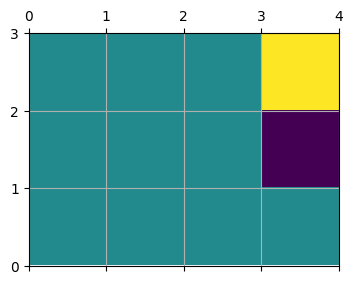

In [7]:
#Define the reward matrix
reward_matrix = np.full((3,4), -0.04)
reward_matrix[0, 3] = 1
reward_matrix[1, 3] = -1
print("Reward Matrix:")
print(reward_matrix)
plt.matshow(reward_matrix,extent=[0, 4, 0, 3])
plt.grid()
plt.show()

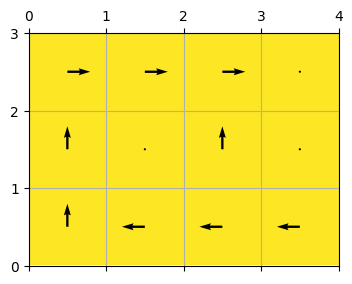

In [8]:
def print_policy(policy_matrix2, V=np.array([]),lstates=[]):
    policy_matrix = policy_matrix2[::-1]
    shape = policy_matrix.shape
    U=np.zeros(policy_matrix.shape)
    R=np.zeros(policy_matrix.shape)
    for row in range(shape[0]):
        for col in range(shape[1]):
            if(policy_matrix[row,col] == -1): 
                U[row,col]=0    
                R[row,col]=0  
            elif(policy_matrix[row,col] == 0): 
                U[row,col]=0    
                R[row,col]=1 
                #policy_string += " ^  "
            elif(policy_matrix[row,col] == 1): 
                U[row,col]=1   
                R[row,col]=0 
                #policy_string += " >  "
            elif(policy_matrix[row,col] == 2): 
                U[row,col]=0    
                R[row,col]=-1 
                #policy_string += " v  "           
            elif(policy_matrix[row,col] == 3):
                U[row,col]=-1   
                R[row,col]=0                 
                #policy_string += " <  "
            elif(np.isnan(policy_matrix[row,col])): 
                U[row,col]=0    
                R[row,col]=0  
                #policy_string += " #  "
    plt.rcParams['figure.figsize'] = (4,3)
    if V.size==0:
        V=np.ones(policy_matrix.shape)
        for x in lstates:
            V[x[0],x[1]]=0.7
        plt.matshow(V,extent=[0, 4, 0, 3],vmin=0, vmax=1)
    else:
        plt.matshow(V,extent=[0, 4, 0, 3])
    plt.grid()
    X, Y = np.meshgrid(np.arange(0.5, 4.5, 1), np.arange(0.5, 3.5, 1))
    Q = plt.quiver(X, Y,U,R)

    plt.show()

policy_matrix = np.array([[1,      1,  1,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      3,  3,   3]])

print_policy(policy_matrix)

In [9]:
transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                              [0.1, 0.8, 0.1, 0.0],
                              [0.0, 0.1, 0.8, 0.1],
                              [0.1, 0.0, 0.1, 0.8]])


In [10]:
gamma = 0.999

def execute_action(s1,a):
    a=np.random.choice([0,1,2,3],p=transition_matrix[int(a)])    
    row = s1[0]
    col = s1[1]
    if(a == 0): 
        new_col = col + 0
        new_row =row - 1
    elif(a == 1): 
        new_col =col + 1
        new_row =row + 0
    elif(a == 2): 
        new_col =col + 0
        new_row =row + 1      
    elif(a == 3):
        new_col =col - 1
        new_row =row + 0              
    new_col = np.clip(new_col, 0, 3)
    new_row = np.clip(new_row, 0, 2)
    if state_matrix[new_row,new_col]==-1: 
        new_col = col
        new_row = row
    return (new_row, new_col), reward_matrix[new_row,new_col],a


In [16]:
def gen_trial():
    lS=[]
    lr=[]
    la=[]
    valid_start_states = [(r,c) for c in range(4) for r in range(3) if state_matrix[r][c]==0]
    state = valid_start_states[np.random.choice(len(valid_start_states))]
    #print_policy(policy_matrix,lstates=[state])
    while state_matrix[state]!=1:
        lS.append(state)
        state,r,a=execute_action(state,policy_matrix[state])
        lr.append(r)
        la.append(a)
        #print_policy(policy_matrix,lstates=[state])
    return lS,lr,la
gen_trial()

([(2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 2)],
 [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, 1.0],
 [3, 3, 0, 0, 1, 1, 0, 1])

In [17]:
def sum_returns(lr,i):
    s=0
    g=1
    for r in range(i,len(lr)):
        s = s+ lr[r]*g
        g = g*gamma
    return s


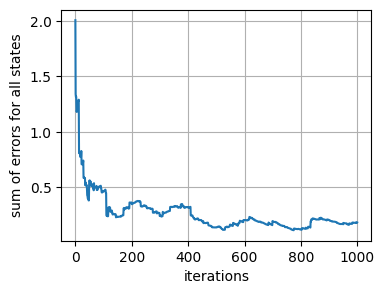

array([[0.83758923, 0.90039566, 0.9591533 , 0.        ],
       [0.78967861, 0.        , 0.67856881, 0.        ],
       [0.73879262, 0.68355627, 0.61271991, 0.32673867]])

In [18]:
# From previous notebooks
TrueV =[[0.84881226, 0.90630541, 0.95748948, 0.],
        [0.797764, 0., 0.69906187, 0.],
        [0.7404234,  0.6895106,  0.64536512, 0.42192624]]

# Exact Monte-Carlo First Visit
lerror=[]
ntrial = 1000
V = np.zeros((3,4))
N = np.zeros((3,4))
for i in range(ntrial):
    lS,lr,la = gen_trial()
    visited = []
    for i,s in enumerate(lS):
        if s not in visited:
            visited.append(s)
            N[s] = N[s]+1
            alpha=1/N[s]
            V[s]=V[s]+alpha*(sum_returns(lr,i)-V[s])
    lerror.append(np.sum(np.abs(TrueV - V)))

plt.plot(lerror)
plt.grid()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()
V

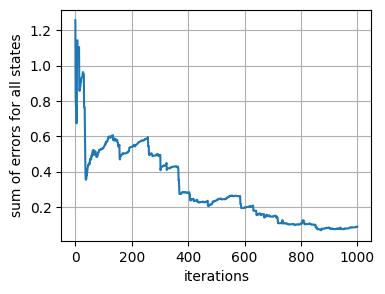

array([[0.8498075 , 0.88231083, 0.95251797, 0.        ],
       [0.80544162, 0.        , 0.71299582, 0.        ],
       [0.73076994, 0.68277531, 0.65837467, 0.4298568 ]])

In [19]:
# Exact Monte-Carlo Every Visit
lerror=[]
ntrial = 1000
V = np.zeros((3,4))
N = np.zeros((3,4))
for i in range(ntrial):
    lS,lr,la = gen_trial()
    for i,s in enumerate(lS):
            N[s] = N[s]+1
            alpha=1/N[s]
            V[s]=V[s]+alpha*(sum_returns(lr,i)-V[s])
    lerror.append(np.sum(np.abs(TrueV - V)))

plt.plot(lerror)
plt.grid()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()
V

[[0.87943695 0.9377074  0.98843609 0.        ]
 [0.82951073 0.         0.89675094 0.        ]
 [0.78075873 0.72758938 0.6931615  0.60938635]] 0.1
[[0.86648853 0.9186613  0.93659507 0.        ]
 [0.81416156 0.         0.68654563 0.        ]
 [0.7448016  0.71116692 0.63003846 0.35111669]] 0.05
[[0.8538817  0.90683111 0.95931957 0.        ]
 [0.79593799 0.         0.55422244 0.        ]
 [0.73393809 0.66781357 0.55545599 0.23472968]] 0.01


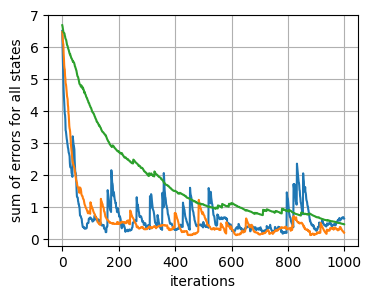

In [20]:
# Alpha Monte-Carlo
for alpha in [0.1,0.05,0.01]:
    lerror=[]
    ntrial = 1000
    V = np.zeros((3,4))
    for i in range(ntrial):
        lS,lr,la = gen_trial()
        visited = []
        for i,s in enumerate(lS):
            if s not in visited:
                visited.append(s)
                V[s]=V[s]+alpha*(sum_returns(lr,i)-V[s])
        lerror.append(np.sum(np.abs(TrueV - V)))

    plt.plot(lerror)
    print(V,alpha)
plt.grid()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()


[[0.88977624 0.93951964 0.99222168 0.        ]
 [0.83421607 0.         0.92364497 0.        ]
 [0.78240662 0.70775486 0.68353175 0.61520381]] 0.2
[[0.80421834 0.87801159 0.8954314  0.        ]
 [0.74858802 0.         0.70230743 0.        ]
 [0.7229724  0.69448885 0.65715758 0.63057245]] 0.1
[[0.85216764 0.90862859 0.94038463 0.        ]
 [0.79404912 0.         0.75555414 0.        ]
 [0.74693429 0.69527657 0.64973488 0.48080019]] 0.05


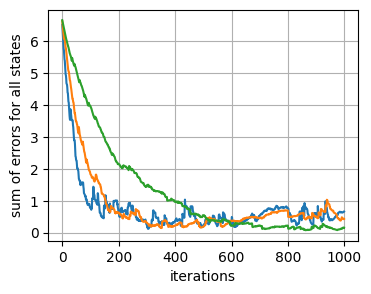

In [21]:
# Alpha Temporal Differences
for alpha in [0.2,0.1,0.05]:
    lerror=[]
    ntrial = 1000
    V = np.zeros((3,4))
    for i in range(ntrial):
        lS,lr,la = gen_trial()
        for i,s in enumerate(lS):
            visited.append(s)
            if i+1<len(lS):
                V[s]=V[s]+alpha*(lr[i]+gamma*V[lS[i+1]]-V[s])
            else:
                V[s]=V[s]+alpha*(lr[i]-V[s])
        lerror.append(np.sum(np.abs(TrueV - V)))

    plt.plot(lerror)
    print(V,alpha)
plt.grid()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()
